**Credit Card Approval Classification**

This project involves building a **classification model** to predict whether a credit card should be granted based on financial and demographic data. The dataset **default_of_credit_card_clients.xls** includes **23 explanatory variables**, such as credit amount, payment history, bill amounts, and previous payments, with a **binary target variable** indicating default status.

Key steps include **data preprocessing, feature selection, model training, evaluation, and optimization**. The final model's performance is assessed using **F1-score and AUC** to ensure accuracy and reliability.

🔍 **More details and comments are available at the end of the file.**

**#0 Imports**

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Data processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Feature selection
from sklearn.feature_selection import RFECV

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Model evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, 
    f1_score, roc_auc_score
)

# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV

# Disable warnings
warnings.filterwarnings('ignore')

**#1 Loading the dataset**

In [2]:
dataframe = pd.read_excel('default_of_credit_card_clients.xls', skiprows=1)
dataframe.set_index('ID', inplace=True)
dataframe.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)
dataframe

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_1                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_AMT4  

In [4]:
dataframe.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In columns PAY_1 - PAY_6, there are numbers that were not described (-2 and 0), so I assume the following description:
"-2 = No consumption, -1 = paid in full, 0 = use of revolving credit (paid minimum only), 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above."

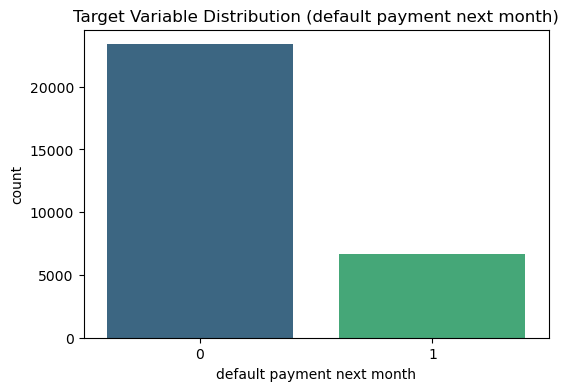

Class proportions:
default payment next month
0    0.7788
1    0.2212
Name: proportion, dtype: float64


In [5]:
# Defining the target variable
target_col = 'default payment next month'  

# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x=dataframe[target_col], palette="viridis")
plt.title("Target Variable Distribution (default payment next month)")
plt.show()
print("Class proportions:")
print(dataframe[target_col].value_counts(normalize=True)) 

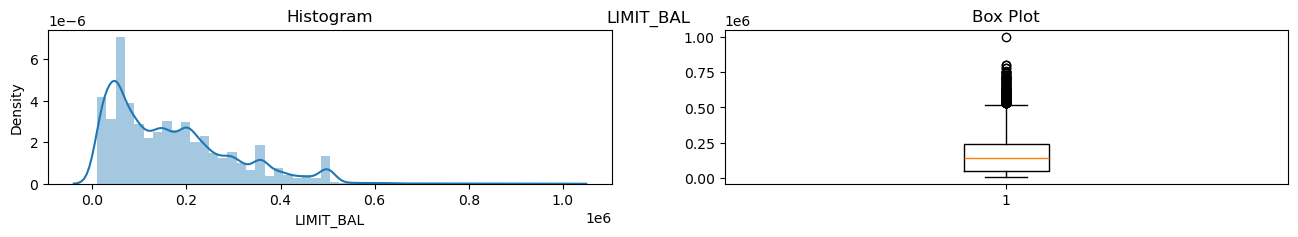

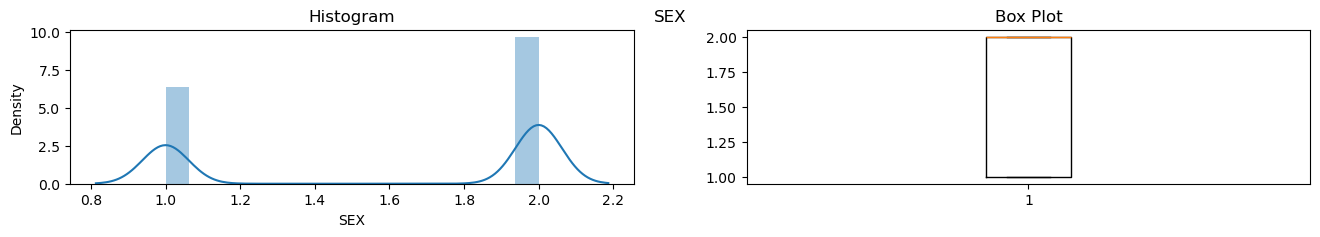

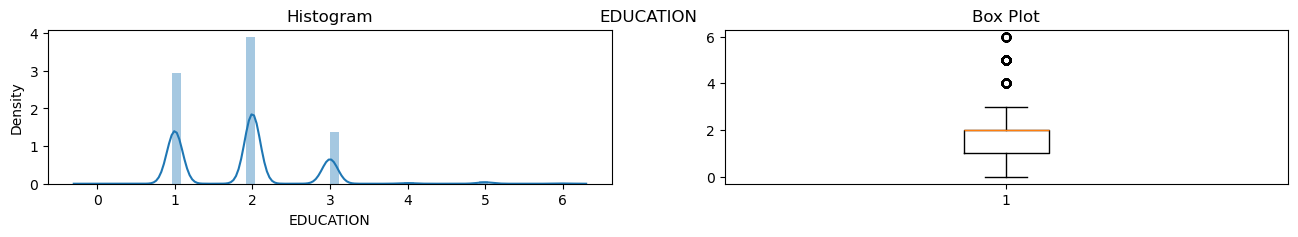

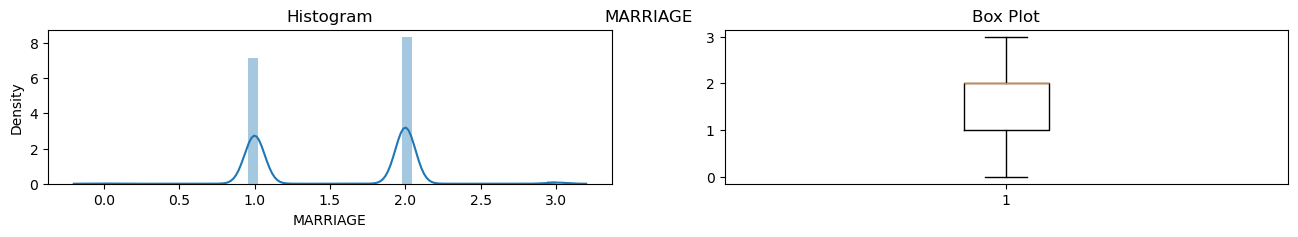

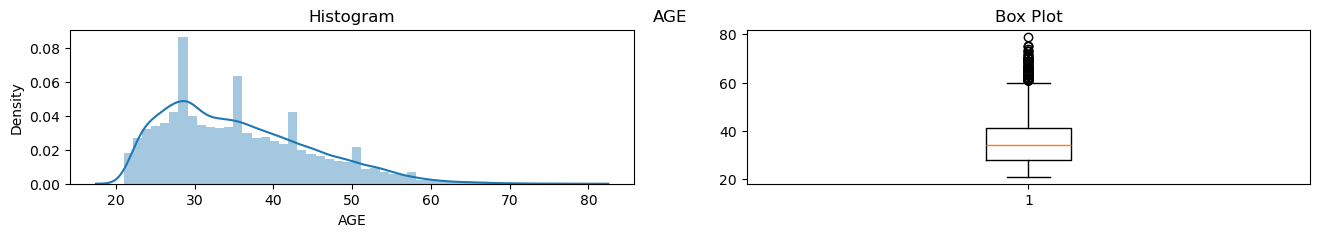

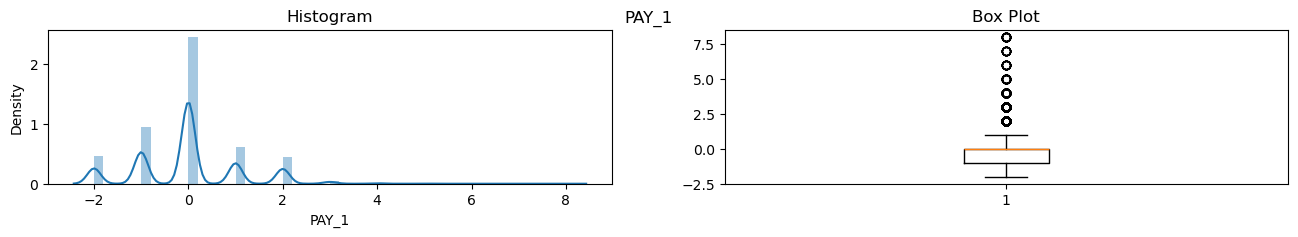

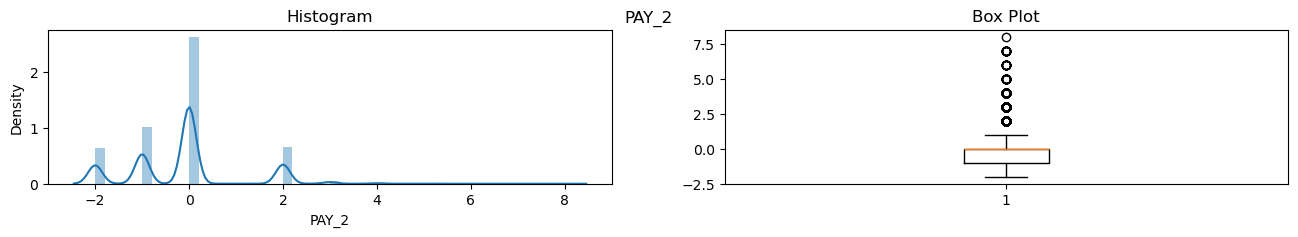

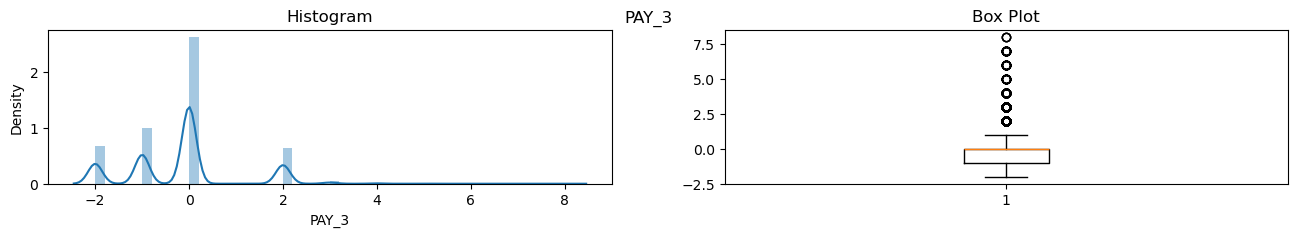

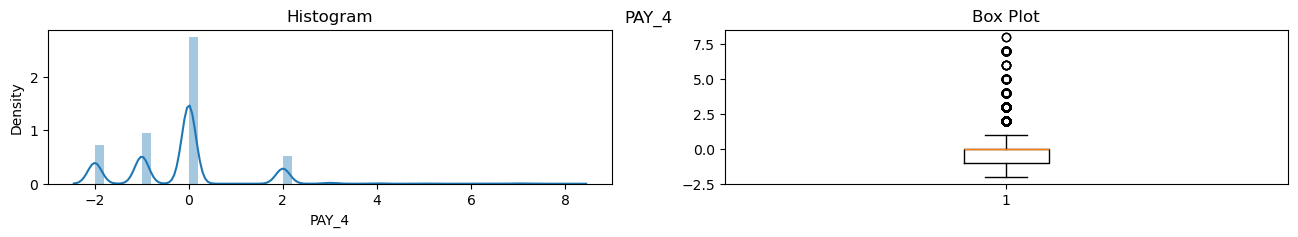

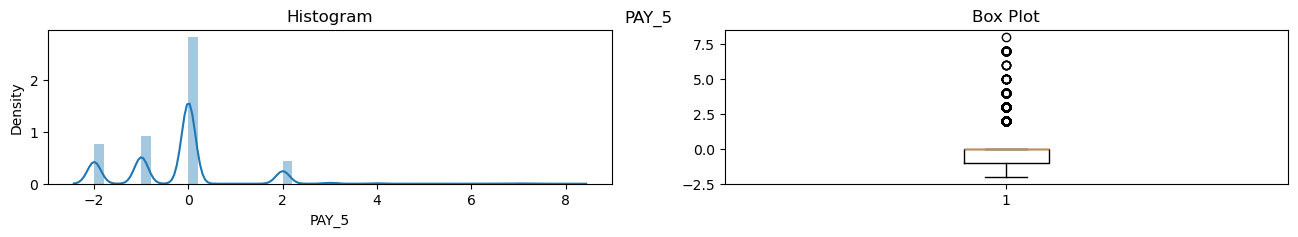

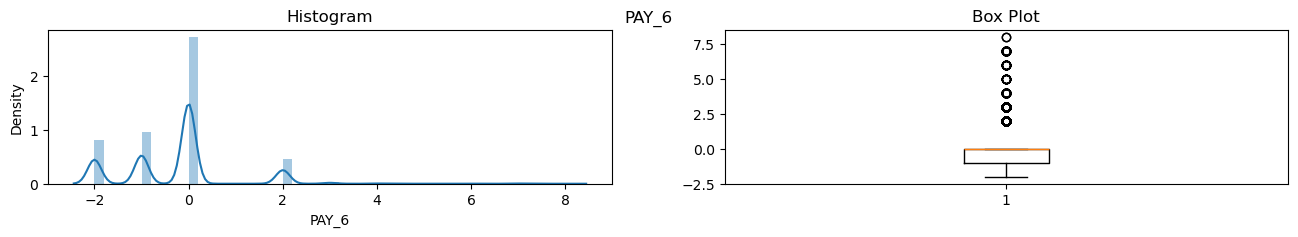

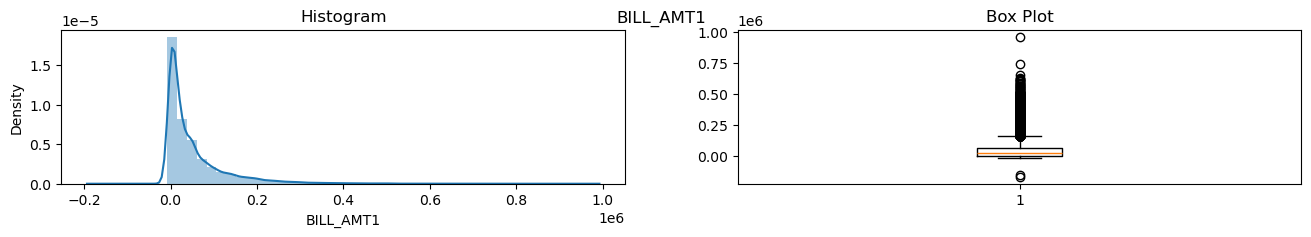

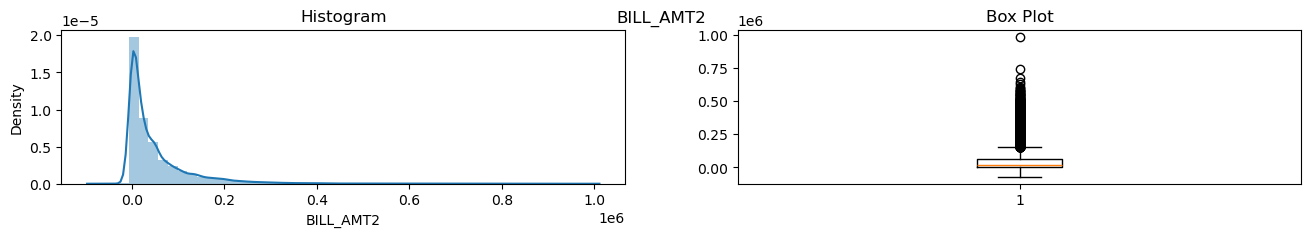

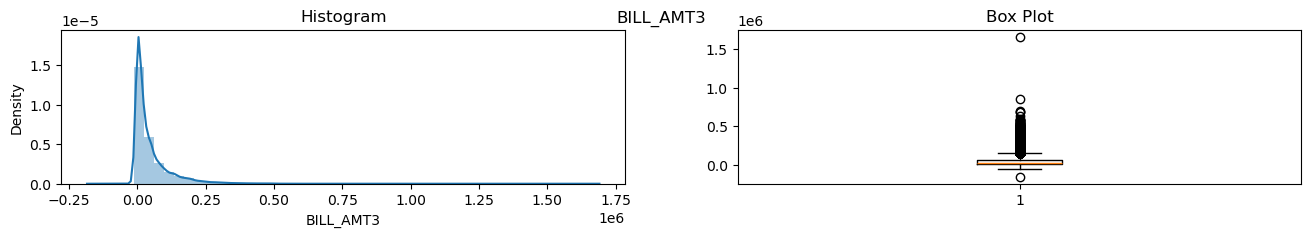

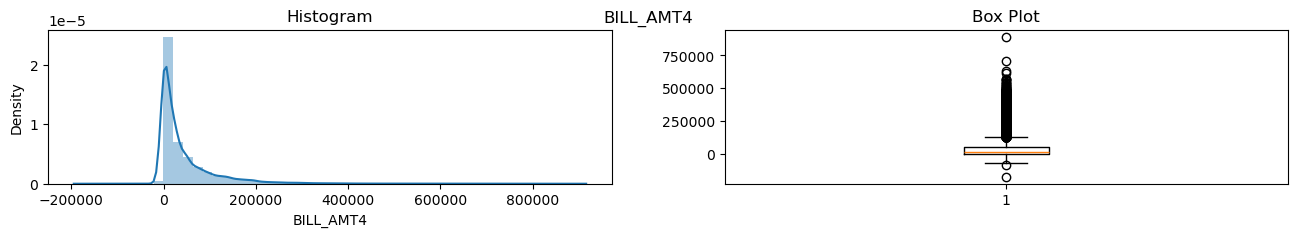

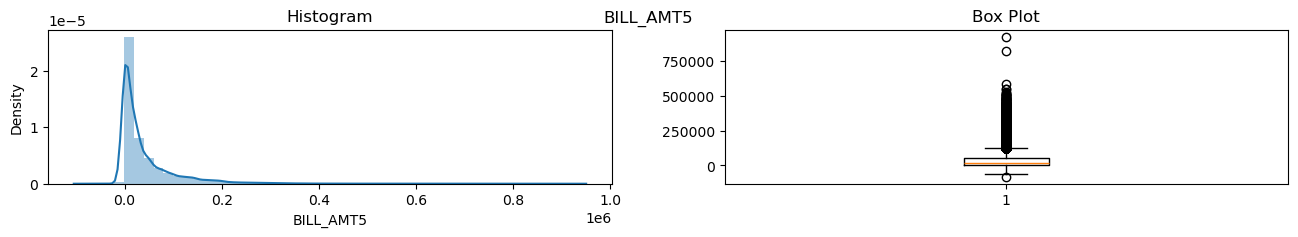

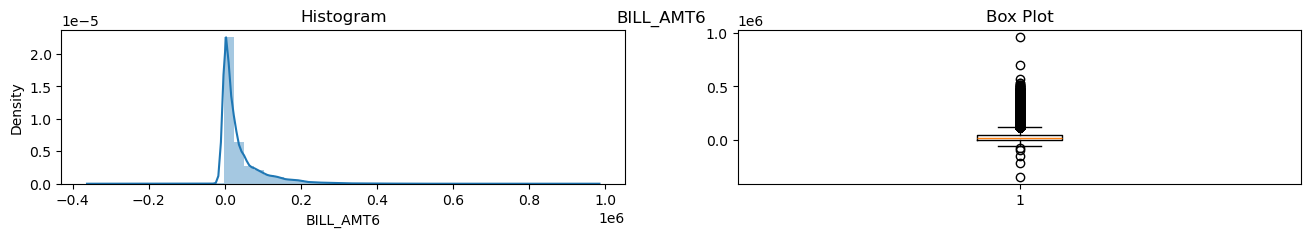

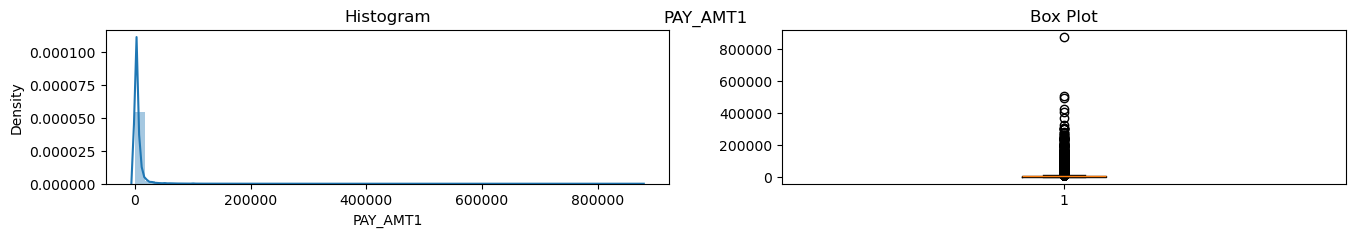

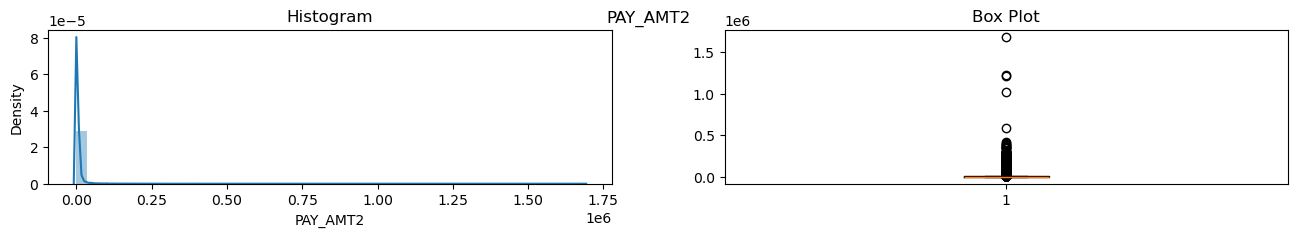

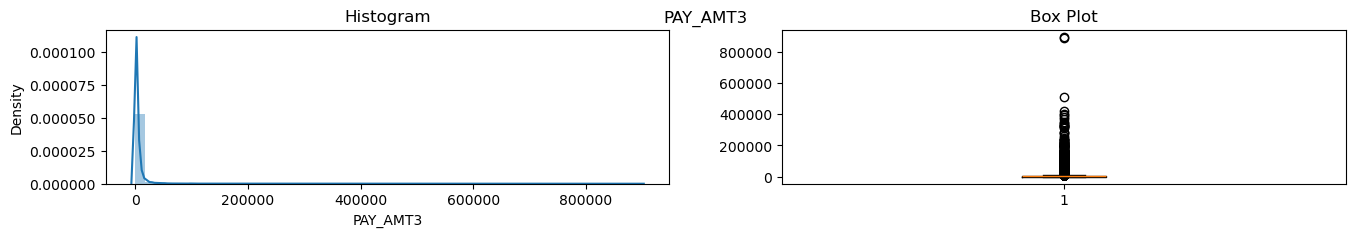

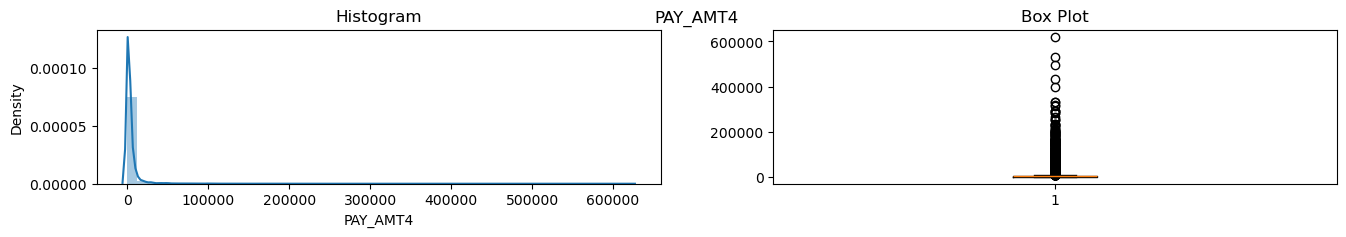

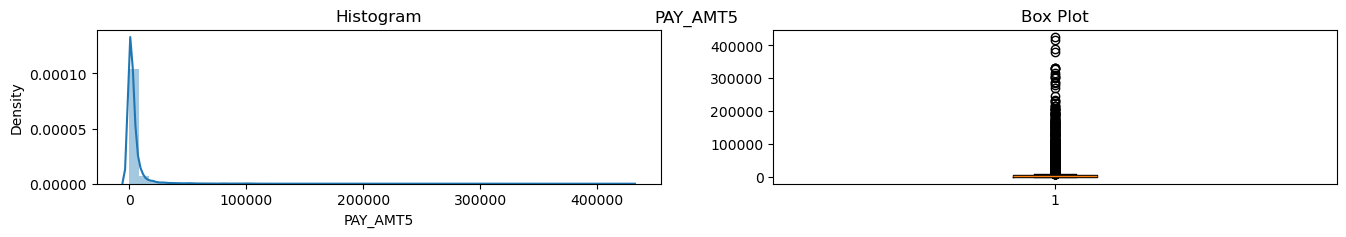

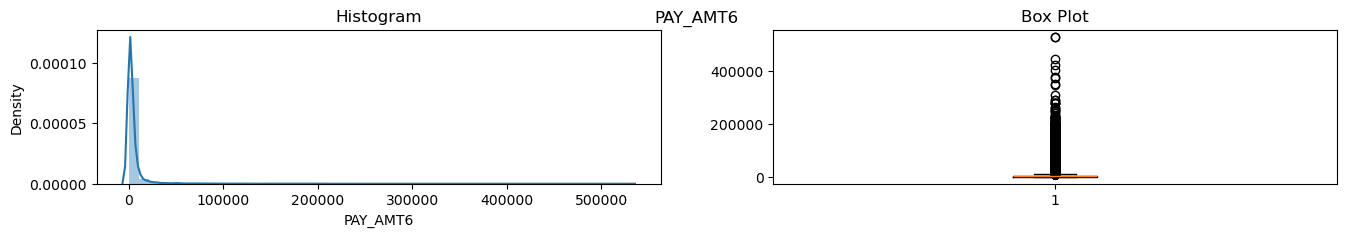

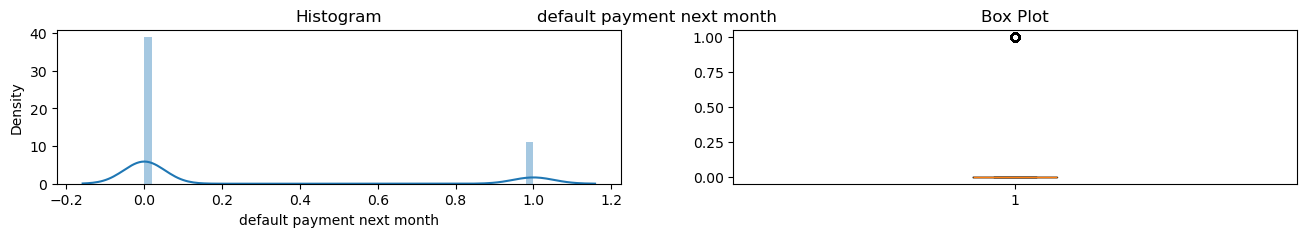

In [6]:
# Visualizing numerical variables
for variable in dataframe.select_dtypes(include=np.number).columns:
    fig = plt.figure(figsize=(16, 2))
    fig.suptitle(variable, fontsize=12)
    plt.subplot(121)
    sns.distplot(dataframe[variable], kde=True, rug=False)
    plt.title('Histogram')
    plt.subplot(122)
    plt.boxplot(dataframe[variable])
    plt.title('Box Plot')
    plt.show()

**#2 Data preparation**

In [7]:
# Adjusting values in categorical columns - grouping values 0, 5, 6 into 4 (others) and grouping value 0 into 3 (others)
dataframe['EDUCATION'] = dataframe['EDUCATION'].replace({0: 4, 5: 4, 6: 4}) 
dataframe['MARRIAGE'] = dataframe['MARRIAGE'].replace(0, 3)

In [8]:
# Splitting variables by type
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
numerical_cols = ['LIMIT_BAL', 'AGE', 
                  'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                  'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                  'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
target_col = 'default payment next month'

**#3 Data splitting**

In [9]:
X = dataframe.drop(columns=[target_col])
y = dataframe[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (24000, 23)
X_test shape: (6000, 23)


**#4 Creating a pipeline for data transformation**

In [10]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

**#5 Data transformation**

In [11]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Getting feature names after transformation
encoded_categorical_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, encoded_categorical_names])

# Converting to DataFrame
X_train_df = pd.DataFrame(X_train_transformed, columns=all_feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_transformed, columns=all_feature_names, index=X_test.index)

**#6 Feature selection**

Most important features: ['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_2', 'EDUCATION_2', 'EDUCATION_3', 'MARRIAGE_2']


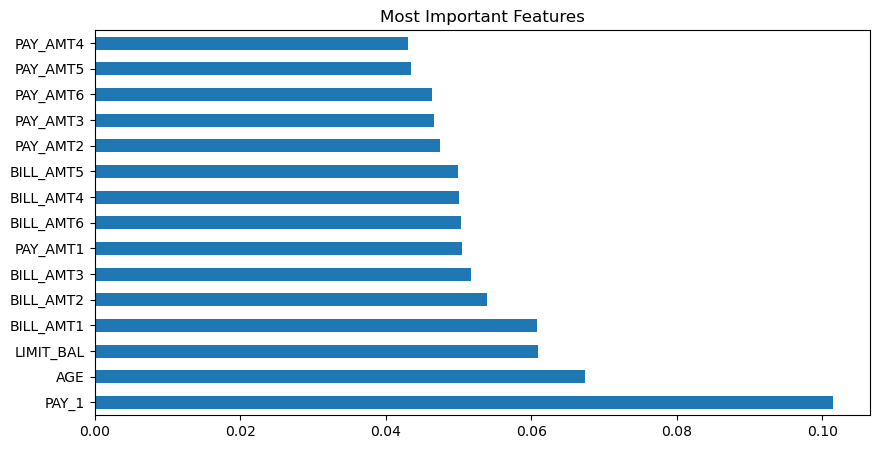

In [12]:
# Creating a baseline model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Recursive Feature Elimination (RFE) with cross-validation
selector = RFECV(rf, step=1, cv=5, scoring='accuracy', n_jobs=-1)
selector.fit(X_train_df, y_train)

# Results
selected_features = X_train_df.columns[selector.support_]
print(f"Most important features: {selected_features.tolist()}")

# Visualizing feature importance
importances = pd.Series(selector.estimator_.feature_importances_, index=selected_features)
importances.nlargest(15).plot(kind='barh', figsize=(10, 5))
plt.title("Most Important Features")
plt.show()

# Updating the dataset for modeling
X_train_selected = X_train_df[selected_features]
X_test_selected = X_test_df[selected_features]

In [13]:
# NEW FUNCTION: Oversampling (SMOTE) to balance classes
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

print("New class distributions after SMOTE:")
print(y_train_resampled.value_counts(normalize=True))

New class distributions after SMOTE:
default payment next month
0    0.666679
1    0.333321
Name: proportion, dtype: float64


**#7 Function for Model Evaluation**

In [14]:
# Initialization of global variables for ROC Curve
fpr_list = []
tpr_list = []
models_names_for_roc = []
metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])

def calculate_metrics(model, name, X_checked, y_checked):
    global metrics_dataframe, fpr_list, tpr_list, models_names_for_roc
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)

    # Model Metrics
    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:, 1])
    new_row = pd.DataFrame({'Model': [name], 'F1_score': [f1_metric], 'AUC': [auc_metric]})
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)

    # Adding ROC Curve results for the model
    fpr, tpr, thresholds = roc_curve(y_checked, predictions_proba[:, 1])
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    models_names_for_roc.append(name)

    # Display Model Metrics
    print(classification_report(y_checked, predictions))

    # Confusion Matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # If this is the first model, draw a new ROC plot
    if len(fpr_list) == 1:
        plt.figure(figsize=(6, 6))
        plt.plot([0, 1], [0, 1], 'k--')  # Baseline (random)

    # Add models to the ROC plot
    for fpr, tpr, name in zip(fpr_list, tpr_list, models_names_for_roc):
        plt.plot(fpr, tpr, label=name)

    # ROC Plot Settings
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    return metrics_dataframe

**#8 Baseline Model**

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4673
           1       0.00      0.00      0.00      1327

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.68      6000



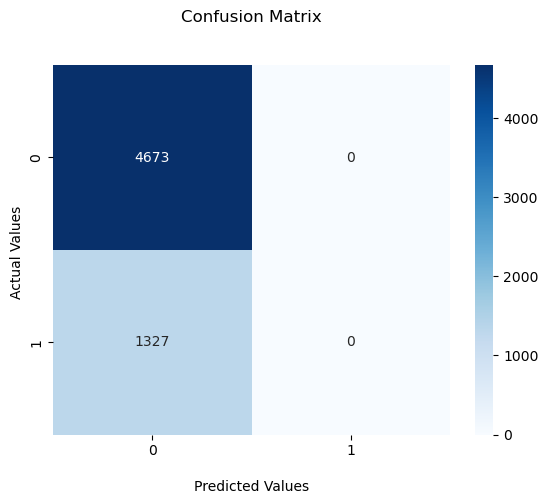

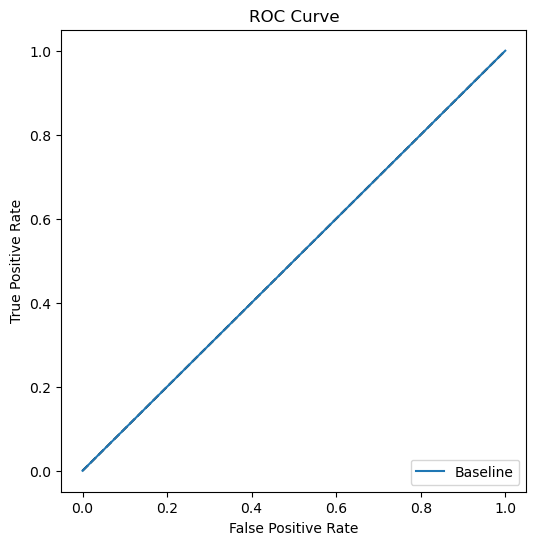

      Model  F1_score  AUC
0  Baseline       0.0  0.5


In [15]:
# Baseline Model: Predicting the Most Frequent Class
baseline_model = DummyClassifier(strategy='most_frequent', random_state=42)

# Model Training
baseline_model.fit(X_train_resampled, y_train_resampled)

# Prediction on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Calculate Metrics
metrics_dataframe = calculate_metrics(baseline_model, "Baseline", X_test_selected, y_test)

# Display Metrics for the Baseline Model
print(metrics_dataframe)

**#9 Modele klasyfikacji**

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      4673
           1       0.36      0.63      0.46      1327

    accuracy                           0.67      6000
   macro avg       0.62      0.66      0.61      6000
weighted avg       0.76      0.67      0.70      6000



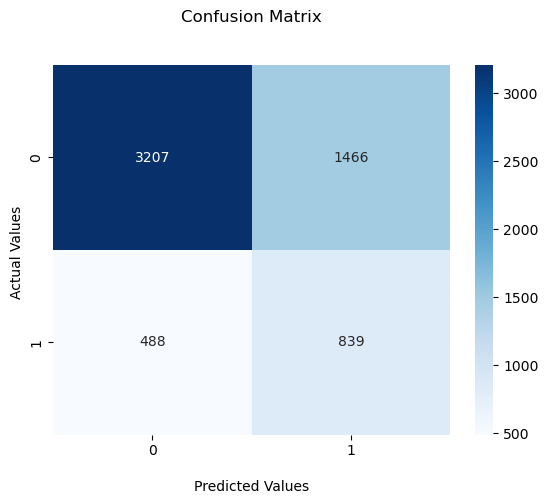

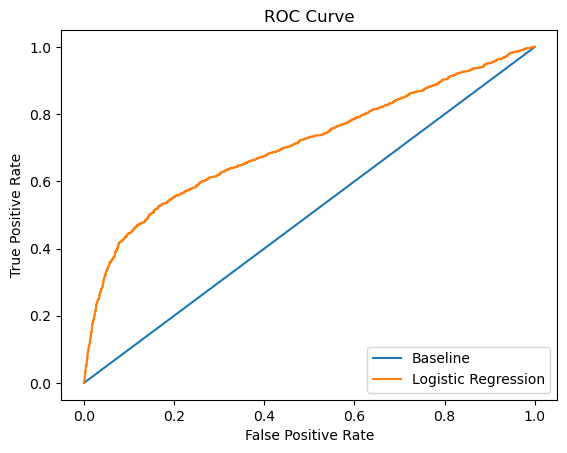

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4673
           1       0.60      0.39      0.47      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.66      0.68      6000
weighted avg       0.79      0.81      0.79      6000



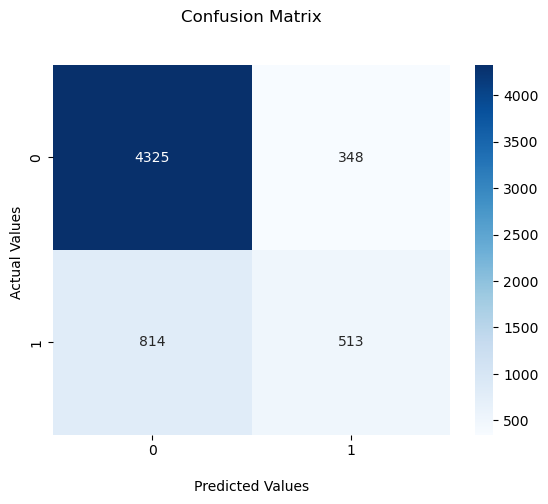

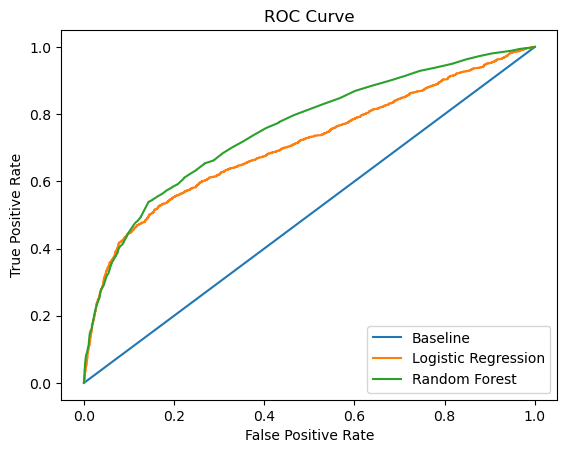

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4673
           1       0.63      0.40      0.49      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.67      0.69      6000
weighted avg       0.80      0.81      0.80      6000



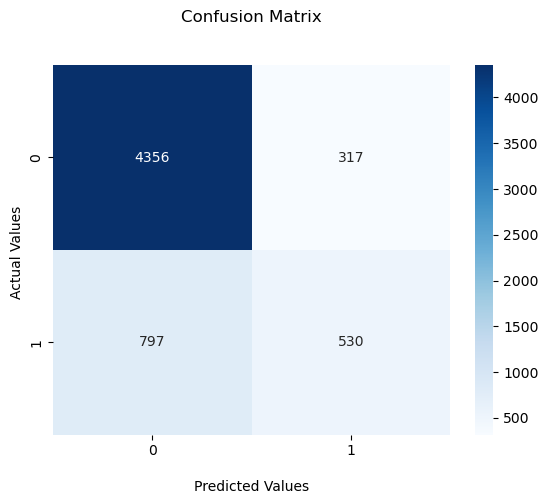

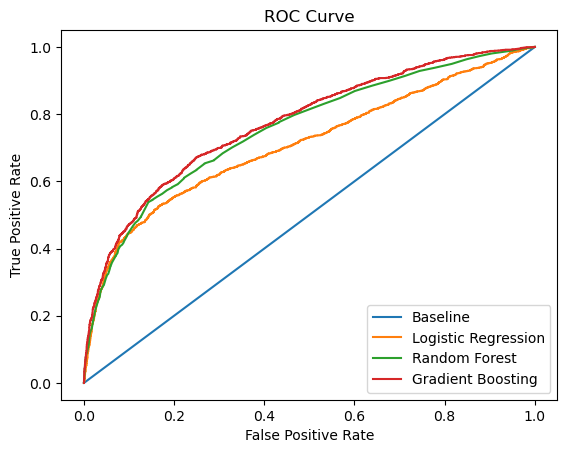

                 Model  F1_score       AUC
0             Baseline  0.000000  0.500000
1  Logistic Regression  0.462004  0.709122
2        Random Forest  0.468921  0.757046
3    Gradient Boosting  0.487580  0.773265


In [16]:
# Definition of Models
models = [
    LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    GradientBoostingClassifier(random_state=42)
]

models_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# Training and Evaluating Models
for model, name in zip(models, models_names):
    model.fit(X_train_resampled, y_train_resampled)  # Model Training
    metrics_dataframe = calculate_metrics(model, name, X_test_selected, y_test)  # Calculate Metrics

# Display Metrics
print(metrics_dataframe)

Best Model: Gradient Boosting achieved the highest AUC score (0.773265).

**#10 Optimization of the Best Model**

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4673
           1       0.61      0.38      0.47      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.66      0.68      6000
weighted avg       0.79      0.81      0.79      6000



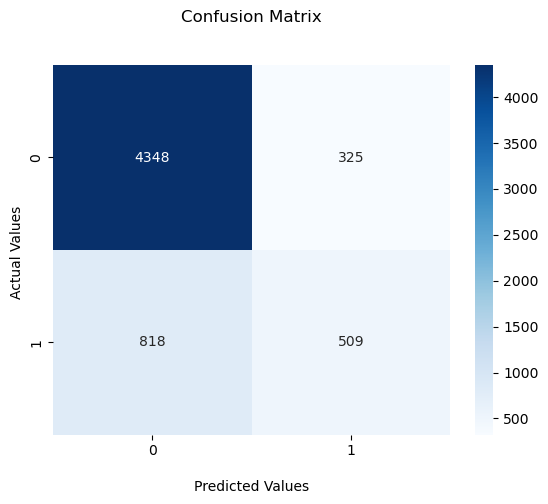

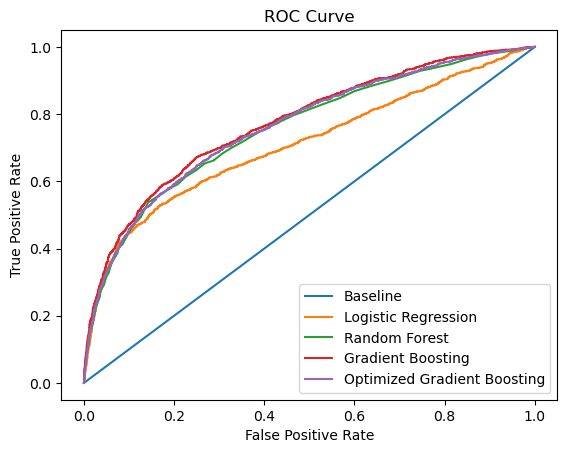

                         Model  F1_score       AUC
0                     Baseline  0.000000  0.500000
1          Logistic Regression  0.462004  0.709122
2                Random Forest  0.468921  0.757046
3            Gradient Boosting  0.487580  0.773265
4  Optimized Gradient Boosting  0.471078  0.762857


In [17]:
# Gradient Boosting Model Initialization
gb_model = GradientBoostingClassifier(random_state=42)

# Parameter Grid for Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of Trees
    'learning_rate': [0.05, 0.1, 0.2],  # Learning Rate
    'max_depth': [3, 5, 7]  # Tree Depth
}

# Grid Search for Hyperparameter Optimization
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)

# Model Training
grid_search.fit(X_train_resampled, y_train_resampled)

# Best Hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluating the Optimized Model
best_gb_model = grid_search.best_estimator_

# Prediction and Metrics Calculation for the Optimized Model
metrics_dataframe = calculate_metrics(best_gb_model, "Optimized Gradient Boosting", X_test_selected, y_test)

# Display Metrics
print(metrics_dataframe)

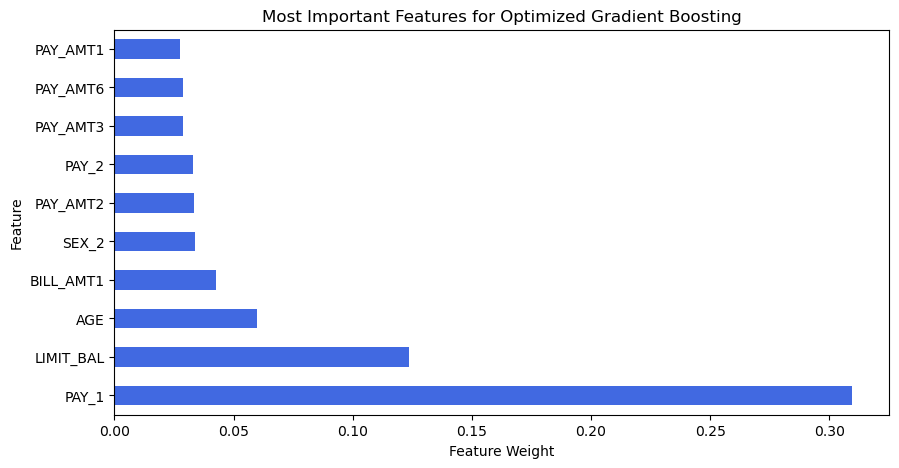

In [18]:
# NEW ANALYSIS: Most Important Features of the Optimized Gradient Boosting Model
importances = pd.Series(best_gb_model.feature_importances_, index=selected_features)
plt.figure(figsize=(10, 5))
importances.nlargest(10).plot(kind='barh', color="royalblue")
plt.title("Most Important Features for Optimized Gradient Boosting")
plt.xlabel("Feature Weight")
plt.ylabel("Feature")
plt.show()

**#11 Summary**

As part of the **credit card approval classification project**, the performance of the following models was analyzed: **Baseline, Logistic Regression, Random Forest**, and **Gradient Boosting**. The best-performing model then underwent **hyperparameter optimization**, resulting in the creation of **Optimized Gradient Boosting**.  

### 🔹 Key Findings:  
- **Gradient Boosting achieved the highest performance** with **AUC = 0.7733 and F1-score = 0.4876**, making it the **best model for class separation**.  
- After hyperparameter tuning, **Optimized Gradient Boosting** showed a **slightly lower performance** (**AUC = 0.7629, F1-score = 0.4711**), indicating that fine-tuning **did not improve effectiveness as expected**.  
- The decline in performance suggests that further tuning led to **overfitting**, reducing the model’s ability to generalize on test data.  

### 🔹 Class-Level Analysis:  
- **The model effectively identifies cases where a credit card should NOT be granted (Class 0).**  
- However, it **struggles with correctly predicting approvals (Class 1).**  
- While the optimized model slightly reduced AUC compared to the base **Gradient Boosting**, it **remains competitive** against other methods like:  
  - **Random Forest (AUC = 0.7570)**  
  - **Logistic Regression (AUC = 0.7091)**  

### 🔥 Conclusion:  
✅ **Gradient Boosting without optimization proved to be the best model for this classification task.**